In [2]:
# Imports
import psycopg2
from PIL import Image
from io import BytesIO
import base64
import matplotlib.pyplot as plt
from psycopg2 import sql
from scipy.ndimage import rotate
import cv2 as cv
import numpy as np
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import io
import base64
from PIL import Image
import psycopg2
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
from skimage.draw import disk

Detected marker IDs: [[ 7]
 [10]
 [ 9]
 [ 8]]
Detected marker corners: (array([[[3143., 4041.],
        [3255., 4064.],
        [3255., 4177.],
        [3143., 4152.]]], dtype=float32), array([[[3315., 1232.],
        [3192., 1249.],
        [3197., 1118.],
        [3317., 1096.]]], dtype=float32), array([[[1402., 3639.],
        [1405., 3723.],
        [1342., 3709.],
        [1340., 3623.]]], dtype=float32), array([[[1319., 1459.],
        [1321., 1557.],
        [1257., 1565.],
        [1254., 1468.]]], dtype=float32))


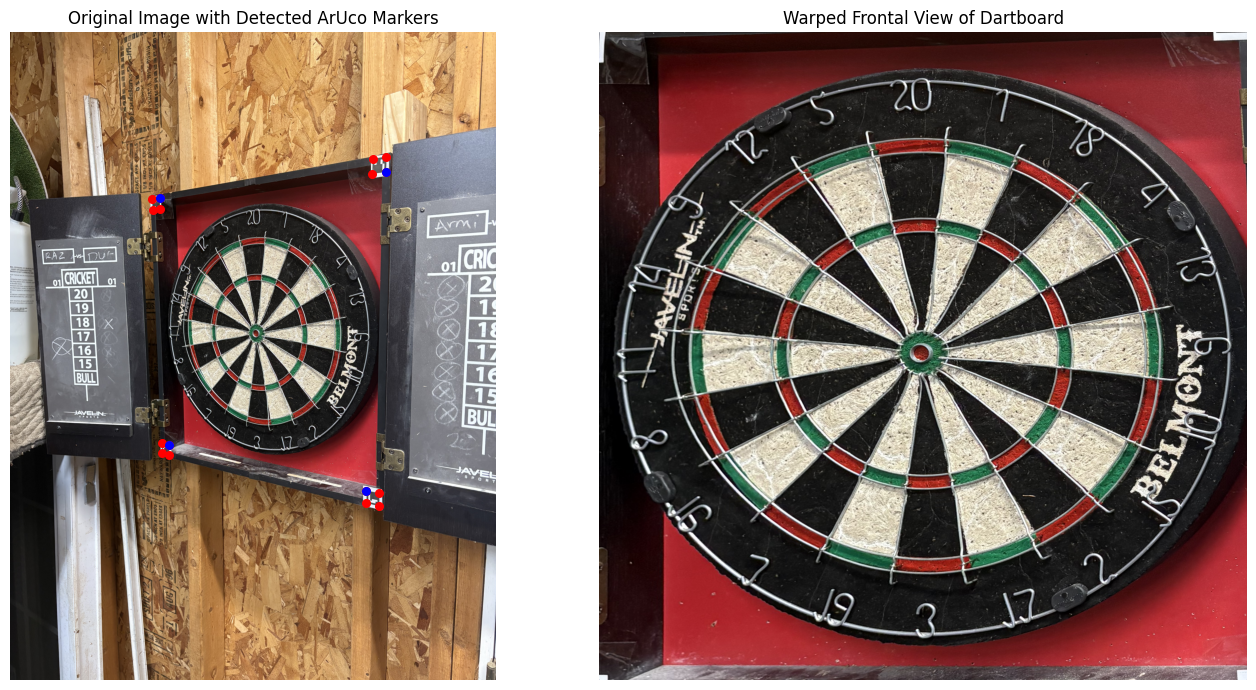

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = cv.imread("../Sample Images/blank_aruco.JPG")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Define the ArUco dictionary and parameters
dictionary = cv.aruco.getPredefinedDictionary(cv.aruco.DICT_ARUCO_ORIGINAL)
parameters = cv.aruco.DetectorParameters()
detector = cv.aruco.ArucoDetector(dictionary, parameters)

# Detect ArUco markers
markerCorners, markerIds, rejectedCandidates = detector.detectMarkers(img)

# Print detected markers for debugging
print("Detected marker IDs:", markerIds)
print("Detected marker corners:", markerCorners)

# Initialize src_rect
src_rect = None

# Check if we found any markers
if markerIds is not None:
    # Create a mapping from marker ID to its corner
    id_to_corner = {8: None, 10: None, 9: None, 7: None}
    
    for i, marker_id in enumerate(markerIds.flatten()):
        if marker_id in id_to_corner:
            id_to_corner[marker_id] = markerCorners[i][0]  # Store the corner for the corresponding ID

    # Check if all required markers were found
    if all(corner is not None for corner in id_to_corner.values()):
        # Map corners based on your description
        src_rect = np.float32([
            id_to_corner[7][0],  # Bottom Right (ID 7) -> Top Left
            id_to_corner[10][0], # Top Right (ID 10) -> Bottom Left
            id_to_corner[9][0],  # Bottom Left (ID 9) -> Top Right
            id_to_corner[8][0]   # Top Left (ID 8) -> Bottom Right
        ])
    else:
        raise ValueError("Not all required ArUco markers were found.")
else:
    raise ValueError("No ArUco markers detected.")

# Define the destination rectangle
width = 2000
height = 2000  
dst_rect = np.float32([
    [width - 1, height - 1],  # id 7
    [width - 1, 0],           # id 10
    [0, height - 1],  # id 9
    [0,0]          # id 8
])

# Compute transform and warp
M = cv.getPerspectiveTransform(src_rect, dst_rect)
warped = cv.warpPerspective(img, M, (width, height))
warped_rgb = cv.cvtColor(warped, cv.COLOR_BGR2RGB)

# Save the resulting warped image
output_path = "../Sample Images/aruco_result_blank.jpg"
cv.imwrite(output_path, warped)

# Plotting the results
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
if markerIds is not None:
    for corner in markerCorners:
        plt.scatter(corner[0][:, 0], corner[0][:, 1], c='red', s=30)
plt.scatter(src_rect[:, 0], src_rect[:, 1], c='blue', s=30)  # Show the src_rect points
plt.title("Original Image with Detected ArUco Markers")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(warped_rgb)
plt.title("Warped Frontal View of Dartboard")
plt.axis('off')

plt.tight_layout()
plt.show()

# Testing detecting scoring regions

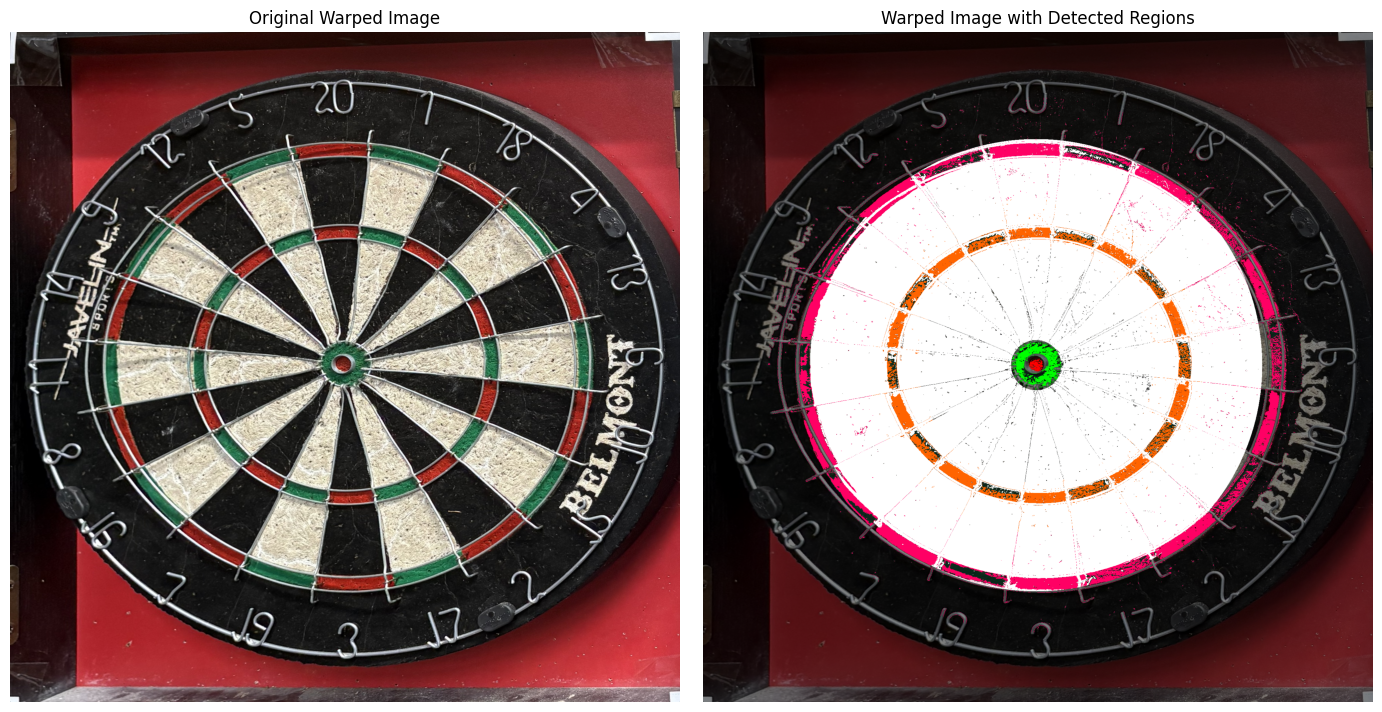

In [4]:
img = cv.cvtColor(cv.imread("../Sample Images/aruco_result_blank.jpg"), cv.COLOR_BGR2RGB)
detected_img = img.copy()
detected_img = (detected_img/2).astype(int)

height, width, colors = img.shape
h_center = int(height/2)
w_center = int(width/2)


# Color averages for region detection
red_avg = np.mean(img[:,:,0])
green_avg = np.mean(img[:,:,1])
blue_avg = np.mean(img[:,:,2])

# Locate bullseye region
radius = 75
bullseye_mask = (img[h_center-radius:h_center+radius, w_center-radius:w_center+radius,0] > red_avg) & \
           (img[h_center-radius:h_center+radius, w_center-radius:w_center+radius,1] < green_avg) & \
           (img[h_center-radius:h_center+radius, w_center-radius:w_center+radius,2] < blue_avg)

detected_img[h_center-radius:h_center+radius, w_center-radius:w_center+radius][bullseye_mask] = [255,0,0]

# Update center with better estimate from bullseye
bullseye_mask_binary = np.zeros((img.shape[0],img.shape[1]))
bullseye_mask_binary[h_center-radius:h_center+radius, w_center-radius:w_center+radius][bullseye_mask] = 1
M = cv.moments(bullseye_mask_binary)
if M["m00"] != 0:
    h_center = int(M["m01"] / M["m00"])
    w_center = int(M["m10"] / M["m00"])
Y,X = np.ogrid[:height, :width]
dist_from_center = np.sqrt((Y-h_center)**2 + (X-w_center)**2)

# Locate inner green circle
radius = 75
green_circle_mask = (dist_from_center <= radius) & \
                    (img[:,:,0] < red_avg) & (img[:,:,1] > green_avg) #& (img[:,:,2] > blue_avg)

detected_img[green_circle_mask] = [0,255,0]

# Locate inner red/green circle
radius = 500
inner_circle_mask = (dist_from_center <= radius) & (dist_from_center >= 350) &\
                    (((img[:,:,0] > red_avg) & (img[:,:,1] < green_avg) & (img[:,:,2] < blue_avg)) | \
                     ((img[:,:,0] < red_avg) & (img[:,:,1] > green_avg) & (img[:,:,2] > blue_avg)))
detected_img[inner_circle_mask] = [255,100,0]

# Locate white/black regions
radius = 675
white_black_circle_mask = (dist_from_center <= radius) & (dist_from_center >= 75) &\
                    (((img[:,:,0] < red_avg) & (img[:,:,1] < green_avg) & (img[:,:,2] < blue_avg)) | \
                     ((img[:,:,0] > red_avg) & (img[:,:,1] > green_avg) & (img[:,:,2] > blue_avg)))

detected_img[white_black_circle_mask]= 255

# Locate outer red/green circle
radius = 800
inner_circle_mask = (dist_from_center <= radius) & (dist_from_center >= 500) &\
                    (((img[:,:,0] > red_avg) & (img[:,:,1] < green_avg) & (img[:,:,2] < blue_avg)) | \
                     ((img[:,:,0] < red_avg) & (img[:,:,1] > green_avg) & (img[:,:,2] > blue_avg)))
detected_img[inner_circle_mask] = [255,0,100]

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Warped Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(detected_img)
plt.title("Warped Image with Detected Regions")
plt.axis('off')

plt.tight_layout()
plt.show()

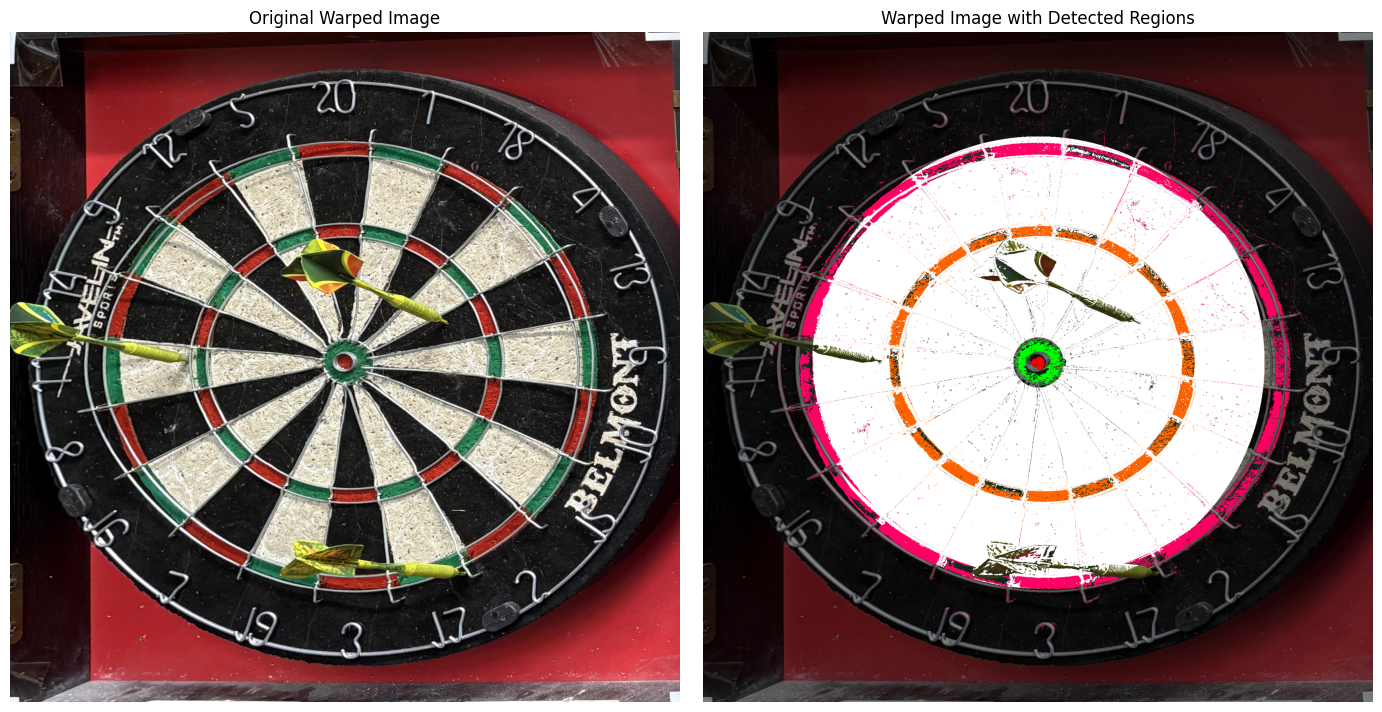

In [4]:
img = cv.cvtColor(cv.imread("../Sample Images/aruco_result_1.jpg"), cv.COLOR_BGR2RGB)
detected_img = img.copy()
detected_img = (detected_img/2).astype(int)

height, width, colors = img.shape
h_center = int(height/2)
w_center = int(width/2)


# Color averages for region detection
red_avg = np.mean(img[:,:,0])
green_avg = np.mean(img[:,:,1])
blue_avg = np.mean(img[:,:,2])

# Locate bullseye region
radius = 75
bullseye_mask = (img[h_center-radius:h_center+radius, w_center-radius:w_center+radius,0] > red_avg) & \
           (img[h_center-radius:h_center+radius, w_center-radius:w_center+radius,1] < green_avg) & \
           (img[h_center-radius:h_center+radius, w_center-radius:w_center+radius,2] < blue_avg)

detected_img[h_center-radius:h_center+radius, w_center-radius:w_center+radius][bullseye_mask] = [255,0,0]

# Update center with better estimate from bullseye
bullseye_mask_binary = np.zeros((img.shape[0],img.shape[1]))
bullseye_mask_binary[h_center-radius:h_center+radius, w_center-radius:w_center+radius][bullseye_mask] = 1
M = cv.moments(bullseye_mask_binary)
if M["m00"] != 0:
    h_center = int(M["m01"] / M["m00"])
    w_center = int(M["m10"] / M["m00"])
Y,X = np.ogrid[:height, :width]
dist_from_center = np.sqrt((Y-h_center)**2 + (X-w_center)**2)

# Locate inner green circle
radius = 75
green_circle_mask = (dist_from_center <= radius) & \
                    (img[:,:,0] < red_avg) & (img[:,:,1] > green_avg) #& (img[:,:,2] > blue_avg)

detected_img[green_circle_mask] = [0,255,0]

# Locate inner red/green circle
radius = 500
inner_circle_mask = (dist_from_center <= radius) & (dist_from_center >= 350) &\
                    (((img[:,:,0] > red_avg) & (img[:,:,1] < green_avg) & (img[:,:,2] < blue_avg)) | \
                     ((img[:,:,0] < red_avg) & (img[:,:,1] > green_avg) & (img[:,:,2] > blue_avg)))
detected_img[inner_circle_mask] = [255,100,0]

# Locate white/black regions
radius = 675
white_black_circle_mask = (dist_from_center <= radius) & (dist_from_center >= 75) &\
                    (((img[:,:,0] < red_avg) & (img[:,:,1] < green_avg) & (img[:,:,2] < blue_avg)) | \
                     ((img[:,:,0] > red_avg) & (img[:,:,1] > green_avg) & (img[:,:,2] > blue_avg)))

detected_img[white_black_circle_mask]= 255

# Locate outer red/green circle
radius = 800
inner_circle_mask = (dist_from_center <= radius) & (dist_from_center >= 500) &\
                    (((img[:,:,0] > red_avg) & (img[:,:,1] < green_avg) & (img[:,:,2] < blue_avg)) | \
                     ((img[:,:,0] < red_avg) & (img[:,:,1] > green_avg) & (img[:,:,2] > blue_avg)))
detected_img[inner_circle_mask] = [255,0,100]

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Warped Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(detected_img)
plt.title("Warped Image with Detected Regions")
plt.axis('off')

plt.tight_layout()
plt.show()

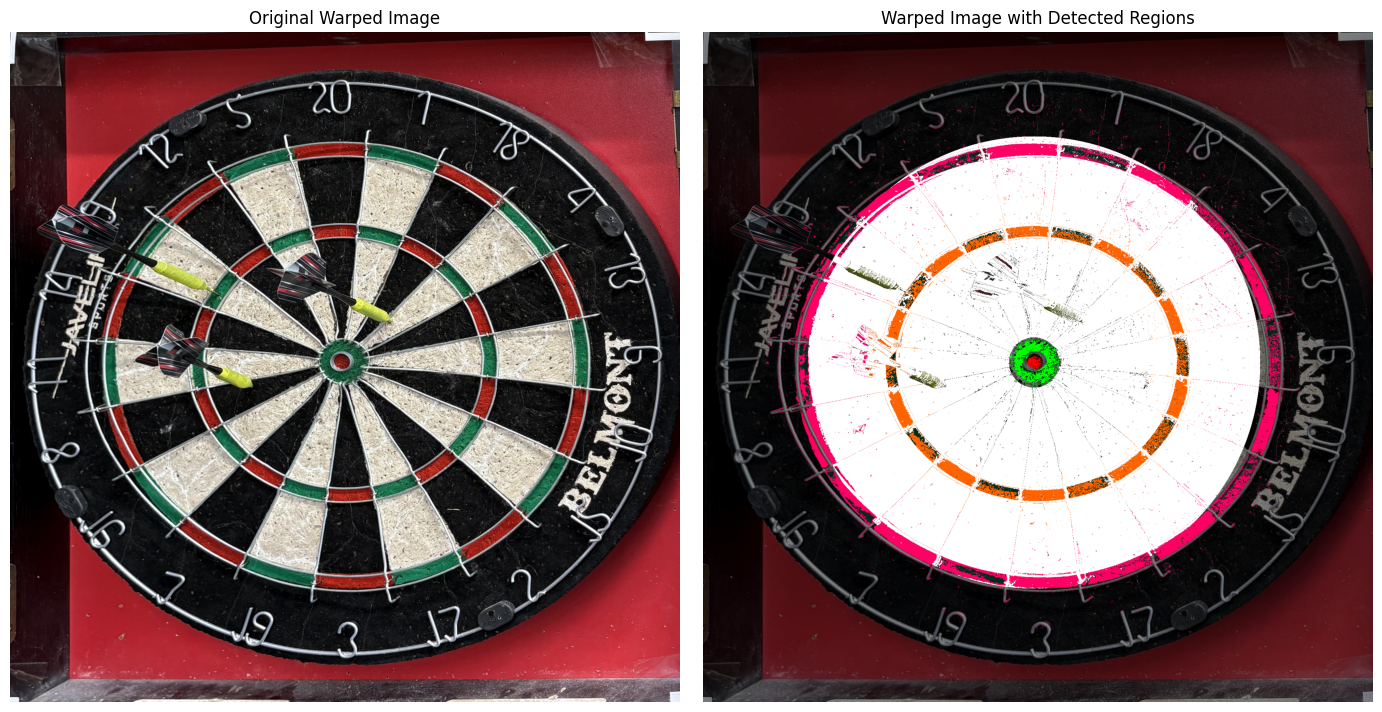

In [5]:
img = cv.cvtColor(cv.imread("../Sample Images/aruco_result_2.jpg"), cv.COLOR_BGR2RGB)
detected_img = img.copy()
detected_img = (detected_img/2).astype(int)

height, width, colors = img.shape
h_center = int(height/2)
w_center = int(width/2)


# Color averages for region detection
red_avg = np.mean(img[:,:,0])
green_avg = np.mean(img[:,:,1])
blue_avg = np.mean(img[:,:,2])

# Locate bullseye region
radius = 75
bullseye_mask = (img[h_center-radius:h_center+radius, w_center-radius:w_center+radius,0] > red_avg) & \
           (img[h_center-radius:h_center+radius, w_center-radius:w_center+radius,1] < green_avg) & \
           (img[h_center-radius:h_center+radius, w_center-radius:w_center+radius,2] < blue_avg)

detected_img[h_center-radius:h_center+radius, w_center-radius:w_center+radius][bullseye_mask] = [255,0,0]

# Update center with better estimate from bullseye
bullseye_mask_binary = np.zeros((img.shape[0],img.shape[1]))
bullseye_mask_binary[h_center-radius:h_center+radius, w_center-radius:w_center+radius][bullseye_mask] = 1
M = cv.moments(bullseye_mask_binary)
if M["m00"] != 0:
    h_center = int(M["m01"] / M["m00"])
    w_center = int(M["m10"] / M["m00"])
Y,X = np.ogrid[:height, :width]
dist_from_center = np.sqrt((Y-h_center)**2 + (X-w_center)**2)

# Locate inner green circle
radius = 75
green_circle_mask = (dist_from_center <= radius) & \
                    (img[:,:,0] < red_avg) & (img[:,:,1] > green_avg) #& (img[:,:,2] > blue_avg)

detected_img[green_circle_mask] = [0,255,0]

# Locate inner red/green circle
radius = 500
inner_circle_mask = (dist_from_center <= radius) & (dist_from_center >= 350) &\
                    (((img[:,:,0] > red_avg) & (img[:,:,1] < green_avg) & (img[:,:,2] < blue_avg)) | \
                     ((img[:,:,0] < red_avg) & (img[:,:,1] > green_avg) & (img[:,:,2] > blue_avg)))
detected_img[inner_circle_mask] = [255,100,0]

# Locate white/black regions
radius = 675
white_black_circle_mask = (dist_from_center <= radius) & (dist_from_center >= 75) &\
                    (((img[:,:,0] < red_avg) & (img[:,:,1] < green_avg) & (img[:,:,2] < blue_avg)) | \
                     ((img[:,:,0] > red_avg) & (img[:,:,1] > green_avg) & (img[:,:,2] > blue_avg)))

detected_img[white_black_circle_mask]= 255

# Locate outer red/green circle
radius = 800
inner_circle_mask = (dist_from_center <= radius) & (dist_from_center >= 500) &\
                    (((img[:,:,0] > red_avg) & (img[:,:,1] < green_avg) & (img[:,:,2] < blue_avg)) | \
                     ((img[:,:,0] < red_avg) & (img[:,:,1] > green_avg) & (img[:,:,2] > blue_avg)))
detected_img[inner_circle_mask] = [255,0,100]

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Warped Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(detected_img)
plt.title("Warped Image with Detected Regions")
plt.axis('off')

plt.tight_layout()
plt.show()

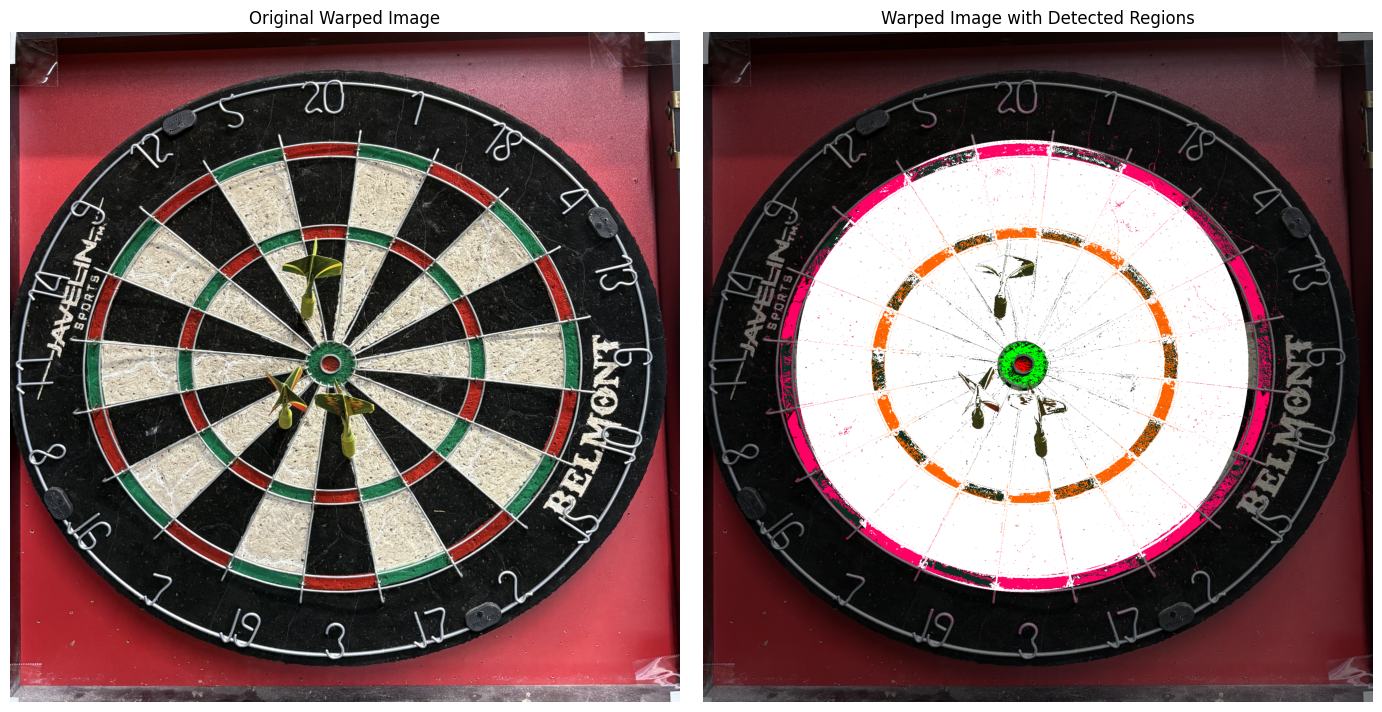

In [6]:
img = cv.cvtColor(cv.imread("../Sample Images/aruco_result_3.jpg"), cv.COLOR_BGR2RGB)
detected_img = img.copy()
detected_img = (detected_img/2).astype(int)

height, width, colors = img.shape
h_center = int(height/2)
w_center = int(width/2)


# Color averages for region detection
red_avg = np.mean(img[:,:,0])
green_avg = np.mean(img[:,:,1])
blue_avg = np.mean(img[:,:,2])

# Locate bullseye region
radius = 75
bullseye_mask = (img[h_center-radius:h_center+radius, w_center-radius:w_center+radius,0] > red_avg) & \
           (img[h_center-radius:h_center+radius, w_center-radius:w_center+radius,1] < green_avg) & \
           (img[h_center-radius:h_center+radius, w_center-radius:w_center+radius,2] < blue_avg)

detected_img[h_center-radius:h_center+radius, w_center-radius:w_center+radius][bullseye_mask] = [255,0,0]

# Update center with better estimate from bullseye
bullseye_mask_binary = np.zeros((img.shape[0],img.shape[1]))
bullseye_mask_binary[h_center-radius:h_center+radius, w_center-radius:w_center+radius][bullseye_mask] = 1
M = cv.moments(bullseye_mask_binary)
if M["m00"] != 0:
    h_center = int(M["m01"] / M["m00"])
    w_center = int(M["m10"] / M["m00"])
Y,X = np.ogrid[:height, :width]
dist_from_center = np.sqrt((Y-h_center)**2 + (X-w_center)**2)

# Locate inner green circle
radius = 75
green_circle_mask = (dist_from_center <= radius) & \
                    (img[:,:,0] < red_avg) & (img[:,:,1] > green_avg) #& (img[:,:,2] > blue_avg)

detected_img[green_circle_mask] = [0,255,0]

# Locate inner red/green circle
radius = 500
inner_circle_mask = (dist_from_center <= radius) & (dist_from_center >= 350) &\
                    (((img[:,:,0] > red_avg) & (img[:,:,1] < green_avg) & (img[:,:,2] < blue_avg)) | \
                     ((img[:,:,0] < red_avg) & (img[:,:,1] > green_avg) & (img[:,:,2] > blue_avg)))
detected_img[inner_circle_mask] = [255,100,0]

# Locate white/black regions
radius = 675
white_black_circle_mask = (dist_from_center <= radius) & (dist_from_center >= 75) &\
                    (((img[:,:,0] < red_avg) & (img[:,:,1] < green_avg) & (img[:,:,2] < blue_avg)) | \
                     ((img[:,:,0] > red_avg) & (img[:,:,1] > green_avg) & (img[:,:,2] > blue_avg)))

detected_img[white_black_circle_mask]= 255

# Locate outer red/green circle
radius = 800
inner_circle_mask = (dist_from_center <= radius) & (dist_from_center >= 500) &\
                    (((img[:,:,0] > red_avg) & (img[:,:,1] < green_avg) & (img[:,:,2] < blue_avg)) | \
                     ((img[:,:,0] < red_avg) & (img[:,:,1] > green_avg) & (img[:,:,2] > blue_avg)))
detected_img[inner_circle_mask] = [255,0,100]

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Warped Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(detected_img)
plt.title("Warped Image with Detected Regions")
plt.axis('off')

plt.tight_layout()
plt.show()